In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Path, PathPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statistics import mean
import numpy as np
import scipy.interpolate
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import cartopy.mpl.geoaxes
import calendar
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon

In [2]:
# Connect to sqlite database
conn = sqlite3.connect('GeoPVWattData.db')
c = conn.cursor()

In [3]:
# Initial table creation in database, only run once
# sql = """CREATE TABLE LatLonData(
#          lat real,
#          lon real,
#          city text,
#          state text,
#          tilt real,
#          azimuth real,
#          azimuthname text,
#          solrad_jan real,
#          solrad_feb real,
#          solrad_mar real,
#          solrad_apr real,
#          solrad_may real,
#          solrad_jun real,
#          solrad_jul real,
#          solrad_aug real,
#          solrad_sep real,
#          solrad_oct real,
#          solrad_nov real,
#          solrad_dec real,
#          solrad_average real,
#          solrad_minus real,
#          solrad_plus real,
#          solrad_annual real,
#          PRIMARY KEY (lat, lon, tilt, azimuth)
#          )"""

In [4]:
# Direction name to use for different azimuth angles
def azimuthtitle(a):
    switcher = {
        0:'North',
        45:'NE', 
        90:'East', 
        135:'SE', 
        180:'South', 
        225:'SW', 
        270:'West', 
        315:'NW' 
    }
    return switcher.get(a,a)

# Plot title creation based on selected solar radation (annual or month) tilt angle and azimuth angle
def ptitle(s,t,a):
    d = {v.lower(): k for k,v in enumerate(calendar.month_abbr)}
    if s == "solrad_annual":
        pts = "Annual"
    else:
        pts = calendar.month_name[d[s[-3:]]]
    
    if t == 0:
        pt = "Horizontal"
        pa = ""
    elif t == 90:
        pt = "Vertical"
        pa = ", " + azimuthtitle(a) + ' Facing'
    else:
        pt = f"Tilt={t}\N{DEGREE SIGN}"
        pa = ", " + azimuthtitle(a) + ' Facing'
    
    return f"Average Solar Irradiance - {pts}, {pt}{pa}"

In [5]:
def plotusa(s,t,a,colmap):

    #########################################
    #Get Data From Database
    #########################################
    ###get max irradiance for given tilt at all orientations for colorbar limit setting
    if t == 0:
        sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE country = 'United States' AND tilt = 0"
        c.execute(sql)
        df = pd.read_sql(sql,conn)
        sol = df[s].tolist()
        maxsol = max(sol)
    else:
        maxsol = 0
        azs = (0,90,180,270)
        for i in azs:
            sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE country = 'United States' AND tilt = {t} AND azimuth = {i}"
            c.execute(sql)
            df = pd.read_sql(sql,conn)
            sol = df[s].tolist()
            if max(sol)>maxsol:
                maxsol = max(sol)

    ###pull data from database
    if t == 0:
        sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE country = 'United States' AND tilt = 0"
    else:
        sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE country = 'United States' AND tilt = {t} AND azimuth = {a}"
    c.execute(sql)

    df = pd.read_sql(sql,conn)

    lons = df['lon'].tolist()
    lats = df['lat'].tolist()
    sol = df[s].tolist()

#     print(min(sol))
#     print(max(sol))

    ###########################
    #Interpolate data
    ###########################
    #setup grid of lat/lon values based on existing data
    x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
    x, y = np.meshgrid(x,y)
    #interpolate solar radiation data over grid of lon/lat values
    z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

    ##########################
    #Create Map Figure
    ##########################
    #Create figure with desired earth projection and lat/lon framing desired
    usleft = -120
    usright = -74
    usbottom = 22.5
    ustop = 50.5
    cenlon = usleft + (usright-usleft)/2
    fig = plt.figure(figsize=[12,6])
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=cenlon))

    ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())

    ##########################
    #Set Contour Levels
    ##########################
    #Contour plot of solar radiation
#     levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
#     levels = np.arange(0.1,8.5,0.1)
#     levels = np.arange(0.1,4.5,0.1)
#     levels = np.arange(round(maxsol/10*10)/10,maxsol,round(maxsol/10*10)/10)
    levels = np.arange(0.5,5,0.5)

    cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                       cmap=plt.get_cmap(colmap))
    cbar = fig.colorbar(cplot,ax=ax)
    cbar.ax.set_ylabel('kWh/m2/Day')


    #Determine title based on inputs
    ax.set_title(ptitle(s,t,a))

    #Color Canada and Mexico gray
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    for country in countries:
        att = country.attributes['ADM0_A3']
        if att == 'CAN' or att == 'MEX':
            
            try:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                              label=country.attributes['ADM0_A3'])
                
#                 ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, alpha = 1.00, linewidth =0.15, edgecolor = "black", label=n.attributes['ADM0_A3']) 
            except Exception as e:
              #print(e)
                list_str_polygons = [str(country.geometry)]
                cmult = MultiPolygon(map(wkt.loads, list_str_polygons))
#                 ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, alpha = 1.00, linewidth =0.15, edgecolor = "black", label=n.attributes['ADM0_A3']) 
            
                ax.add_geometries(cmult, ccrs.PlateCarree(),
                                  facecolor=(0.9, 0.9, 0.9),edgecolor=(0,0,0),
                                  label=country.attributes['ADM0_A3'])

    #Add in state lines
    states = NaturalEarthFeature(category="cultural", scale="10m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")



    #add coastlines, lat/lon lines, color ocean white
    ax.coastlines('50m', linewidth=0.8)
    ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
    ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

    ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


    fname = s + '_t' + str(t) + "_a" + str(a) + "_US"
    plt.savefig(f'Images\\{fname}.png',dpi=300,bbox_inches='tight')
    plt.show()


In [6]:
def ploteurope(s,t,a,colmap):

    #########################################
    #Get Data From Database
    #########################################
    ###get max irradiance for given tilt at all orientations for colorbar limit setting
    ###NOTE still using max values from US even though this is for Europe plot
    if t == 0:
        sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE country = 'United States' AND tilt = 0"
        c.execute(sql)
        df = pd.read_sql(sql,conn)
        sol = df[s].tolist()
        maxsol = max(sol)
    else:
        maxsol = 0
        azs = (0,90,180,270)
        for i in azs:
            sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE country = 'United States' AND tilt = {t} AND azimuth = {i}"
            c.execute(sql)
            df = pd.read_sql(sql,conn)
            sol = df[s].tolist()
            if max(sol)>maxsol:
                maxsol = max(sol)

    ###pull data from database
    if t == 0:
        sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE lat > 15 AND lat < 85 AND lon > -45 AND lon < 75 AND tilt = 0"
    else:
        sql = f"SELECT lat, lon, {s} FROM LatLonData WHERE lat > 15 AND lat < 85 AND lon > -45 AND lon < 75 \
                AND tilt = {t} AND azimuth = {a}"
    c.execute(sql)
    # df=DataFrame(c.fetchall())
    df = pd.read_sql(sql,conn)

    lons = df['lon'].tolist()
    lats = df['lat'].tolist()
    sol = df[s].tolist()

#     print(min(sol))
#     print(max(sol))

    #setup grid of lat/lon values based on existing data
    x, y = np.linspace(min(lons), max(lons), 500), np.linspace(min(lats), max(lats), 500)
    x, y = np.meshgrid(x,y)
    #interpolate solar radiation data over grid of lon/lat values
    z = scipy.interpolate.griddata((lons, lats), sol, (x, y), method='linear')

    #Create figure with desired earth projection and lat/lon framing desired
    usleft = -12
    usright = 39.75
    usbottom = 31.5
    ustop = 63
    cenlon = usleft + (usright-usleft)/2
    fig = plt.figure(figsize=[12,6])
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=cenlon))
    ax.set_extent([usleft, usright, usbottom, ustop], ccrs.Geodetic())


    levels = [.25,.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5,5,5.5,6,6.5,7,7.5,8]
    levels = np.arange(0.1,9,0.25)
    # levels = np.arange(0.1,4.5,0.25)
#     levels = np.arange(maxsol/10,maxsol,maxsol/10)
    levels = np.arange(round(maxsol/10*10)/10,maxsol,round(maxsol/10*10)/10)
    levels = np.arange(0.5,5,0.5)
#     if t==0:
#          levels = np.arange(0,maxsol,round(maxsol/10*4)/4)
    cplot=plt.contourf(x, y,z, levels,transform=ccrs.PlateCarree(),extend='both',
                       cmap=plt.get_cmap(colmap))
    cbar = fig.colorbar(cplot,ax=ax)


    ax.set_title(ptitle(s,t,a))


    ax.add_feature(cfeature.BORDERS)

    #add coastlines, lat/lon lines, color ocean white
    ax.coastlines('50m', linewidth=0.8)
    ax.add_feature(NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))
    ax.add_feature(NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='k', facecolor=(0.84 , 0.93, 0.93)))

    ax.gridlines(color=(0.5,0.5,0.5), linestyle="dotted")


    fname = s + '_t' + str(t) + "_a" + str(a) + "_Europe"
    plt.savefig(f'Images\\{fname}.png', dpi=300,bbox_inches='tight')
    plt.show()


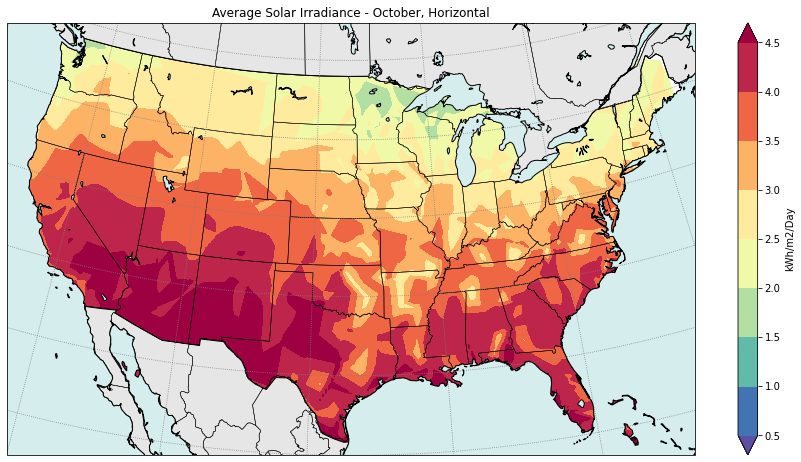

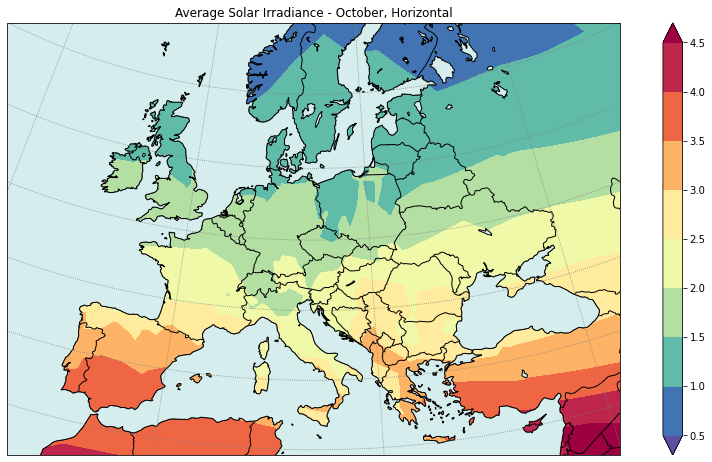

In [7]:
# Select desired radiation to plot average - 'solrad_average', or month e.g. 'solrad_jan', 'solrad_feb'
s = 'solrad_oct'

# Select desired tilt to plot. If 0 selected, azimuth does not matter and only 1 plot shown
t = 0

# Select list of desired azimuth angles to plot
alist = (0,90,180,270)


# Contour colorbar selection
# colmap = 'jet'
# colmap = 'hot_r'
# colmap = 'YlOrRd'
colmap = 'Spectral_r'

if t ==0:
    plotusa(s,t,0,colmap)
    ploteurope(s,t,0,colmap)
else:
    for i, a in enumerate(alist):
        plotusa(s,t,a,colmap)
    for i, a in enumerate(alist):    
        ploteurope(s,t,a,colmap)




In [336]:
conn.close()